In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 2)
import time
import random
import tensorflow as tf
print("Tensor Flow version {}".format(tf.__version__))

/Users/valentin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/valentin/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc", line #513
  (fname, cnt))


Tensor Flow version 1.0.0


# Yet Another RNN Tutorial

## The core concept

Neural Network lern a mapping between an input X and an output Y. Neural Networks approximate a function $f$ such as $y=f(x)$.

<img width="500px" src="images/simpleN.png"\>


Let imagine that we have a single neural network which is able to predict a word in a sentence given the previous one. Then, the same neural network can be used to predict words iteratively. Then for each word $x_t$ in the sentence, we have $x_{t+1} = f(x_t)$.

<img width="700px" src="images/x0Nx1Nx2.png"\>

With this example, it's important to notice that the same neural network is used to predict the next step and this for every words in the sentence. Then, knowing the first word, we can generate the first sentence recursively using one single network. This is what we call a recurrent neural network. And this is a big deal because it reduces the overall number of parameters to find during training.

As a conclusion, a recurrent neural network is an architecture were a single neural network is used recursively to predict the next element of a sequence given the previous element. If $f$ is the function approximated by this neural network.

## Limitations

I hope you get the idea behind the recurrent neural networks at this point: using a single neural network recursively. However, this architecture is obvisouly too simple and we won't be able to do really interesting things with it because we can only model sequences with very short dependencies: at each step, the element must be a transformation of the previous elmement ($x_{t+1} = f(x_t)$), not a big deal. It seems impossible for to model complex data structures such as music, time series or natural language.

## Transmitting Information

In order to model more complex data structures, we need to transmit an history of all the previous elements. So at each step our neural network would be able to make a prediction using not only the previous element but the three past elements or even more. A simple way to implment this manually would be to feed more inputs to the function $f$. Using the example of the sentence, we can feed one dimension for the t-th word and one dimension for the (t-1)-th word:
- For the first step the neural network will predict "are", store it in the first dimension and place "Cats" in the second dimension
- For the second step the neural network will predict "evil" using the two dimensions "Cats" and "are". Then it will store "evil" in the second dimension for further predictions. 


<img width="700px" src="images/one_step_memory.png"\>


This "hack" is in total accordance with the core concept, we approximate a function $f$ which predicts $X_{t+1}$ given $X_t$. We have:


$$\left(\begin{array}{c}x_t\\ x_{t-1}\end{array}\right) = f\left(\begin{array}{c}x_{t-1}\\ x_{t-2}\end{array}\right)$$

Obviously, here we have shown one possibility to store information. In practice, the neural network will be trained to find its own optimal way to store and transmit information, which is often more efficient that what we can code by hand.

## Application: Time Series Forecasting

In this example we would like to "summarize" a whole sequence to predict the next element. This can be used to predict gas price or the exchange rate of the following day. However, predicting such data is a very difficult because it depends on an incredibly high number of parameters such as social events, political factor or the price of oil, etc..

Here we are going to simulate simple time series using sinusoids. Few samples are shown in the next plot, each line corresponds to one sequence. 

The goal will be to predict the last point of the curve given a few input points: the model needs to learn to spot a trend in the input sequence extrapolate it to produce the right result. In order to do so, the model needs to be able to transmit the information about the whole input sequence because the following point doesn't depend only on the last input point but it depends on all previous ones.

### Simulating data

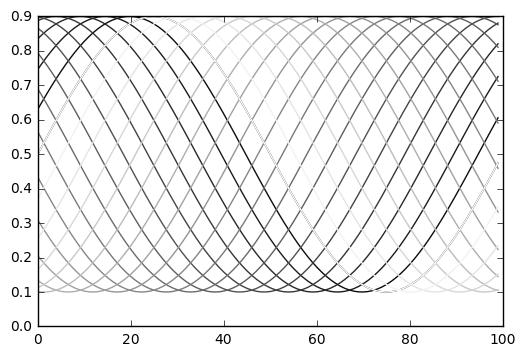

In [4]:
def get_samples(n_samples, phase):
    T = 100
    return [  [ 0.5 + 0.4 * np.sin( float(x) * 2 * np.pi / 100.0 + 2 * np.pi * phase )] for x in xrange(n_samples) ]

for t in np.linspace(0,1,20):
    plt.plot(get_samples(100, t), color=[t]*3 )
plt.show()

### Training data

Then we need to generate batches of data to feed the model. For each element in a batch, we take 40 points from a random sample and use the 20 first points as input sequence X, then we use the 40th point as label y. The model will be trained to predict $y = f(X)$ where X is a sequence of 20 points and y the value at the 40th step.

In [120]:
signal_size = 20     # let's say we want to generate a signal of size 20
time_before_prediction = 20    # predicting the following step is easy, we want to generate the values after 20 unit of time
prediction_size = 1 # we want to predict only one point
def get_batch(batch_len):
    xs = []
    ys = []
    for _ in xrange(batch_len):
        phase = random.random()
        samples = get_samples(signal_size+time_before_prediction, phase)
        xs.append(samples[:signal_size])
        ys.append(samples[-1])
    return xs,ys

In [121]:
# an element from a batch: a sequence of 20 points and a single target point 
get_batch(1)[0]

[[[0.11371826237763494],
  [0.12100177928221245],
  [0.12978102901614624],
  [0.14002136389159386],
  [0.15168236998516621],
  [0.16471802663321866],
  [0.17907688805438643],
  [0.19470228638258019],
  [0.21153255530916365],
  [0.22950127345170246],
  [0.24853752648881405],
  [0.26856618702659796],
  [0.28950821109213631],
  [0.31128095008394269],
  [0.33379847694823528],
  [0.35697192529375965],
  [0.38070984010683806],
  [0.40491853868252436],
  [0.42950248034744304],
  [0.45436464351517719]]]

### The Recurrent Neural Network

####  Placeholder to feed the data and Hyperparameters

In [122]:
tf.reset_default_graph()

batch_size = 64
state_size = 16
data_dim = 1
dtype = tf.float32
learning_rate = 0.001
epoches = 200

previous_steps = tf.placeholder(dtype, [batch_size, signal_size, data_dim] , name='previous_steps_placeholder')
next_step = tf.placeholder(dtype, [batch_size, data_dim], name='next_step_placeholder')

### The RNN cell

The weights and biases of the neural network used at each step of the recurrent neural network

In [123]:
W = tf.Variable(tf.random_uniform([data_dim + state_size, state_size], 0, 1), dtype=dtype)
b = tf.Variable(tf.zeros( [state_size] ), dtype=dtype)

### The Recurrent Neural Network itself


For this purpose we need to encode the whole sequence input in a memory vector which can be used to predict the next value. Again, we use a single cell which encode each input into the memory vector $s_t$. We have:

$$s_{t+1}= f\left(\begin{array}{c}s_{t}\\ x_{t}\end{array}\right) = tanh(\left(\begin{array}{c}s_{t}\\ x_{t}\end{array}\right) W + b )$$


<img width="700px" src="images/encoder.png"\>



In [124]:
def static_rnn(inputs):
    # initial memory
    initial_memory = tf.zeros([batch_size, state_size], dtype=dtype)
    memory = initial_memory
    rnn_inputs = tf.unstack(inputs, signal_size, axis=1)
    for x in rnn_inputs:
        # group inputs (previous memory s_t-1 + current input x_t)
        cell_inputs = tf.concat( [memory, x], 1) 
        # applying the cell
        memory = tf.nn.tanh( tf.add( tf.matmul( cell_inputs , W), b ) )
    return memory

memory = static_rnn(previous_steps)

### Interpreting the memory

We use a linear leayer to "interpret" the sequence memory. This layer project the memory vector of size n to an output of size 1.

In [125]:
next_predicted_values = tf.contrib.layers.fully_connected(memory , data_dim, activation_fn=None)

### Objective function 

The distance from the ground truth used to train our network

In [126]:
RMSE =  tf.reduce_mean( tf.pow( next_step - next_predicted_values, 2) ) # RMSE^2
with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    with tf.name_scope('train_step'):
        optimizer =  tf.train.AdamOptimizer(learning_rate).minimize(RMSE)

## Training

Training the model using SGD.

In [127]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
xx = []
costs = []
for step in range(10000):
    batch_xs, batch_ys = get_batch(batch_size)
    batch_ys = [y for y in batch_ys]
    _,cost= sess.run([optimizer, RMSE], 
                                    feed_dict={previous_steps: batch_xs, next_step: batch_ys})        
    xx.append(step)
    costs.append(cost)
    # Display logs per epoch step
    if step % 1000 == 0:
        print "step:", step, "| loss:" , cost

step: 0 | loss: 0.137858
step: 1000 | loss: 0.0773762
step: 2000 | loss: 0.0284718
step: 3000 | loss: 0.00331869
step: 4000 | loss: 0.000774218
step: 5000 | loss: 0.000222679
step: 6000 | loss: 0.000176053
step: 7000 | loss: 3.39514e-05
step: 8000 | loss: 3.26467e-05
step: 9000 | loss: 1.44322e-05


## Plotting the results

The model successfuly encode the whole sequence and pass the information to the interpretation layer which predicts the right output. The model is fed only with the "input sequence" while the rest of the sequence is unknown to the model. The model was trained on the last point on the full data.

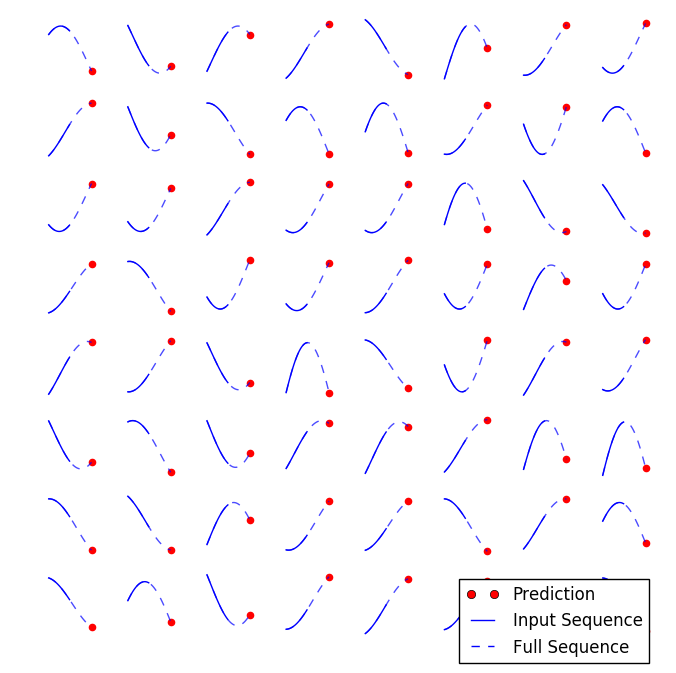

In [115]:
n = 8
fig = plt.figure()
fig.set_figheight(n)
fig.set_figwidth(n)

batch_xs, batch_ys = get_batch(n**2)
fig_i=1
for xs, ys in zip(batch_xs, batch_ys):
    dd = [ xs for x in xrange(batch_size)]
    pred= sess.run([next_predicted_values], feed_dict={previous_steps: dd}) 
    ax1 = fig.add_subplot(n,n,fig_i)
    xxs = []
    yys = []
    for k, xx in enumerate(xs+ys):
        xxs.append(k)
        yys.append(xx)
    ax1.plot(xxs,yys,'r--',color='blue', alpha=0.7)
    xxs = []
    yys = []
    for k, xx in enumerate(xs):
        xxs.append(k)
        yys.append(xx)
    ax1.plot(xxs,yys,color='blue')
    ax1.scatter(xxs+time_before_prediction,pred[0][0], color='red')
    ax1.axis('off')
    fig_i += 1
    
    
# legend
handles, labels = ax1.get_legend_handles_labels()
display = (0,1,2)
# custom legend to plot
preds = plt.Line2D((0,1),(0,0), color='r', marker='o', linestyle='')
input_data = plt.Line2D((0,1),(0,0),color='blue')
real_data = plt.Line2D((0,1),(0,0), color='blue', linestyle='--')
#Create legend
ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[preds,input_data,real_data],
          [label for i,label in enumerate(labels) if i in display]+['Prediction', 'Input Sequence', 'Full Sequence'])

plt.show()

# What's Next?

Now we have seen that a neural network is able to encode a full sequence to produce one output. In the next tutorial we will try to generate a full sequence using reucrrent neural networks.